In [1]:
import pandas as pd
df = pd.read_csv('flooding.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398782 entries, 0 to 398781
Data columns (total 18 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   time                                 398782 non-null  float64
 1   source                               398782 non-null  int64  
 2   destination                          398782 non-null  int64  
 3   length                               398782 non-null  float64
 4   info                                 398782 non-null  float64
 5   transmission_rate_per_1000_ms        398782 non-null  float64
 6   reception_rate_per_1000_ms           398782 non-null  float64
 7   transmission_average_per_sec         398782 non-null  float64
 8   reception_average_per_sec            398782 non-null  float64
 9   transmission_count_per_sec           398782 non-null  float64
 10  reception_count_per_sec              398782 non-null  float64
 11  transmission_

In [2]:
df.head()

,time,source,destination,length,info,transmission_rate_per_1000_ms,reception_rate_per_1000_ms,transmission_average_per_sec,reception_average_per_sec,transmission_count_per_sec,reception_count_per_sec,transmission_total_duration_per_sec,reception_total_duration_per_sec,dao,dis,dio,category,label
0,0.000,39,9999,0.0,1.0,0.455915,0.453760,0.651939,0.602542,0.455513,0.453217,0.647481,1.000000,0.0,0.0,0.505311,Flooding,1
1,0.029,39,9999,0.0,1.0,0.546376,0.451854,0.562410,0.574839,0.546240,0.451169,0.639066,0.417750,0.0,0.0,0.602969,Normal,0
2,0.031,39,9999,0.0,1.0,0.477600,0.643320,0.590334,0.550347,0.477600,0.644056,0.495172,0.601483,0.0,0.0,0.672366,Normal,0
3,0.043,39,9999,0.0,1.0,0.449653,0.635719,0.587023,0.513923,0.449515,0.636046,0.452128,0.558999,0.0,0.0,0.666124,Normal,0
4,0.045,39,9999,0.0,1.0,0.554547,0.580181,0.440554,0.520545,0.554830,0.580524,0.422353,0.513192,0.0,0.0,0.698465,Normal,0


In [3]:
# Check if 'label' is in the columns
if 'label' in df.columns:
    print(df['label'].value_counts())
else:
    print("'label' column does not exist in the DataFrame.")


0    263206
1    135576
Name: label, dtype: int64


data preprocessing

In [4]:
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE  # Import t-SNE
import pandas as pd

# Assuming df is your DataFrame containing the dataset

# Instantiate StandardScaler
scalar = StandardScaler()

# Drop the 'category' column
X = df.drop(['label', 'category'], axis=1)  # Drop both the target variable and the categorical column
y = df['label']  # Target variable

# Store column names
column_names = X.columns.tolist()

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=23)  # Assuming 2 components for visualization
X_embedded = tsne.fit_transform(X)

# Split the embedded data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_embedded, y, test_size=0.2, random_state=23)

# Check value counts of 'label' column before undersampling
print("Value counts of 'label' column before undersampling:")
print(y_train.value_counts())

# Instantiate the random sampler for undersampling
undersampler = RandomUnderSampler(random_state=42)

# Balance only the training set
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# Check value counts of 'label' column after undersampling
print("\nValue counts of 'label' column after undersampling:")
print(pd.Series(y_train_resampled).value_counts())

# Scale the embedded data
X_scaled = scalar.fit_transform(X_embedded)

# Convert the scaled data back to a DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=['TSNE_Component_1', 'TSNE_Component_2'])

# Display the first 10 rows of the scaled data
print("First 10 rows of the scaled data:")
print(X_scaled_df.head(10))


Value counts of 'label' column before undersampling:
0    210552
1    108473
Name: label, dtype: int64

Value counts of 'label' column after undersampling:
0    108473
1    108473
Name: label, dtype: int64
First 10 rows of the scaled data:
   TSNE_Component_1  TSNE_Component_2
0          0.275509         -1.433487
1          0.244476         -1.464260
2          0.236712         -1.470025
3          0.236584         -1.470331
4          0.237420         -1.469379
5          0.257990         -1.535311
6          0.240538         -1.466277
7          0.332879         -1.858781
8          0.237164         -1.469967
9          0.236803         -1.470210


SVC (Support Vector Classifier) modeling

In [5]:
from sklearn.svm import SVC
model_svc = SVC()  #By default, the kernel used is "rbf" (Radial Basis Function), which is a non-linear kernel.
model_svc.fit(X_train_resampled, y_train_resampled)

SVC()

checking Accuracy

In [6]:
from sklearn.metrics import accuracy_score
# Make predictions
y_pred_svc = model_svc.predict(X_test)
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_svc)

print("Accuracy:", accuracy)

Accuracy: 0.8288300713417004


In [7]:
import joblib
# Save the best model to disk
joblib.dump(model_svc, 'svm_flooding_model.pkl')

['svm_flooding_model.pkl']

              precision    recall  f1-score   support

           0       0.98      0.75      0.85     52654
           1       0.67      0.97      0.79     27103

    accuracy                           0.83     79757
   macro avg       0.83      0.86      0.82     79757
weighted avg       0.88      0.83      0.83     79757



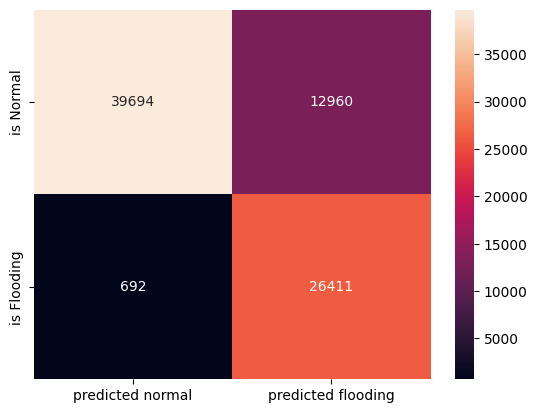

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns

# Make predictions using the best model
y_predict = model_svc.predict(X_test)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_predict, labels=[0, 1])

# Create DataFrame for confusion matrix
confusion = pd.DataFrame(conf_matrix, index=['is Normal', 'is Flooding'], columns=['predicted normal', 'predicted flooding'])

# Visualize confusion matrix using heatmap
sns.heatmap(confusion, annot=True, fmt='d')

# Print classification report
print(classification_report(y_test, y_predict))


Correlation

In [10]:
import pandas as pd
import scipy.stats as stats

# Assuming your data is stored in a DataFrame called df
columns_of_interest = ['length', 'transmission_rate_per_1000_ms', 'reception_rate_per_1000_ms', 
                       'transmission_average_per_sec', 'reception_average_per_sec', 
                       'transmission_count_per_sec', 'reception_count_per_sec', 
                       'transmission_total_duration_per_sec', 'reception_total_duration_per_sec']

# Selecting only the numerical columns
numerical_data = df[columns_of_interest]

# Compute the Pearson correlation coefficient matrix
corr_matrix = numerical_data.corr()

# Display the correlation matrix
print(corr_matrix)


                                       length  transmission_rate_per_1000_ms  \
length                               1.000000                       0.132811   
transmission_rate_per_1000_ms        0.132811                       1.000000   
reception_rate_per_1000_ms          -0.405757                       0.156110   
transmission_average_per_sec        -0.019259                       0.797060   
reception_average_per_sec           -0.208386                       0.105409   
transmission_count_per_sec           0.133961                       0.999987   
reception_count_per_sec             -0.404847                       0.156157   
transmission_total_duration_per_sec  0.202814                       0.099117   
reception_total_duration_per_sec    -0.597030                      -0.002579   

                                     reception_rate_per_1000_ms  \
length                                                -0.405757   
transmission_rate_per_1000_ms                          0.156110  

In [11]:
# Compute the Spearman correlation coefficient matrix
spearman_corr_matrix = numerical_data.corr(method='spearman')

# Display the correlation matrix
print(spearman_corr_matrix)

                                       length  transmission_rate_per_1000_ms  \
length                               1.000000                       0.322348   
transmission_rate_per_1000_ms        0.322348                       1.000000   
reception_rate_per_1000_ms          -0.544223                       0.047018   
transmission_average_per_sec        -0.080152                      -0.008996   
reception_average_per_sec           -0.073452                      -0.089433   
transmission_count_per_sec           0.324019                       0.999925   
reception_count_per_sec             -0.542030                       0.047824   
transmission_total_duration_per_sec  0.288362                       0.209112   
reception_total_duration_per_sec    -0.472323                      -0.154120   

                                     reception_rate_per_1000_ms  \
length                                                -0.544223   
transmission_rate_per_1000_ms                          0.047018  

In [12]:

# Compute the Kendall tau correlation coefficient matrix
kendall_corr_matrix = numerical_data.corr(method='kendall')

# Display the correlation matrix
print(kendall_corr_matrix)

c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_stats_py.py:5278: RuntimeWarning: overflow encountered in longlong_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


                                       length  transmission_rate_per_1000_ms  \
length                               1.000000                       0.234842   
transmission_rate_per_1000_ms        0.234842                       1.000000   
reception_rate_per_1000_ms          -0.407704                       0.035568   
transmission_average_per_sec        -0.060217                      -0.081024   
reception_average_per_sec           -0.064532                      -0.069695   
transmission_count_per_sec           0.236235                       0.998057   
reception_count_per_sec             -0.405961                       0.036183   
transmission_total_duration_per_sec  0.209043                       0.141806   
reception_total_duration_per_sec    -0.362679                      -0.106017   

                                     reception_rate_per_1000_ms  \
length                                                -0.407704   
transmission_rate_per_1000_ms                          0.035568  

In [13]:
import numpy as np

# Compute the correlation coefficient matrix
corr_matrix = np.corrcoef(numerical_data, rowvar=False)

# Display the correlation matrix
print(corr_matrix)

[[ 1.          0.13281128 -0.40575697 -0.0192591  -0.20838637  0.13396073
  -0.4048473   0.20281401 -0.59703002]
 [ 0.13281128  1.          0.15611025  0.79706032  0.10540912  0.9999868
   0.15615703  0.09911711 -0.00257873]
 [-0.40575697  0.15611025  1.          0.1616679   0.76285666  0.15575559
   0.99999103 -0.08753235  0.22024727]
 [-0.0192591   0.79706032  0.1616679   1.          0.1457574   0.79649877
   0.16164913  0.23457302  0.07307426]
 [-0.20838637  0.10540912  0.76285666  0.1457574   1.          0.10519655
   0.76254415 -0.03906634  0.22709132]
 [ 0.13396073  0.9999868   0.15575559  0.79649877  0.10519655  1.
   0.155809    0.09927613 -0.00361048]
 [-0.4048473   0.15615703  0.99999103  0.16164913  0.76254415  0.155809
   1.         -0.08754102  0.21931295]
 [ 0.20281401  0.09911711 -0.08753235  0.23457302 -0.03906634  0.09927613
  -0.08754102  1.         -0.05876236]
 [-0.59703002 -0.00257873  0.22024727  0.07307426  0.22709132 -0.00361048
   0.21931295 -0.05876236  1.    

In [14]:
import pandas as pd
corr_coefficient = df['length'].corr(df['transmission_rate_per_1000_ms'])
print("Correlation coefficient between column1 and column2:", corr_coefficient)


Correlation coefficient between column1 and column2: 0.13281127758543176


In [15]:
spearman_corr = df['length'].corr(df['transmission_rate_per_1000_ms'], method='spearman')

kendall_corr = df['length'].corr(df['transmission_rate_per_1000_ms'], method='kendall')

print("Spearman correlation coefficient:", spearman_corr)
print("Kendall correlation coefficient:", kendall_corr)

Spearman correlation coefficient: 0.3223478011060625
Kendall correlation coefficient: 0.2348419784212282


c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_stats_py.py:5278: RuntimeWarning: overflow encountered in longlong_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


In [16]:
# Select only numeric columns
numeric_df = df.select_dtypes(include='number')

# Compute the correlation matrix
correlation_matrix = numeric_df.corr()

print(correlation_matrix)


                                         time    source  destination  \
time                                 1.000000 -0.087087    -0.152328   
source                              -0.087087  1.000000    -0.073714   
destination                         -0.152328 -0.073714     1.000000   
length                               0.439471  0.010262    -0.576445   
info                                -0.120523 -0.092404     0.886681   
transmission_rate_per_1000_ms        0.072638 -0.360569    -0.017776   
reception_rate_per_1000_ms          -0.096745 -0.071610     0.171672   
transmission_average_per_sec         0.042806 -0.169861     0.024901   
reception_average_per_sec            0.088133 -0.059797     0.194375   
transmission_count_per_sec           0.073090 -0.360936    -0.018490   
reception_count_per_sec             -0.096607 -0.071389     0.170840   
transmission_total_duration_per_sec  0.125026  0.012955    -0.237789   
reception_total_duration_per_sec    -0.147607 -0.079476     0.70

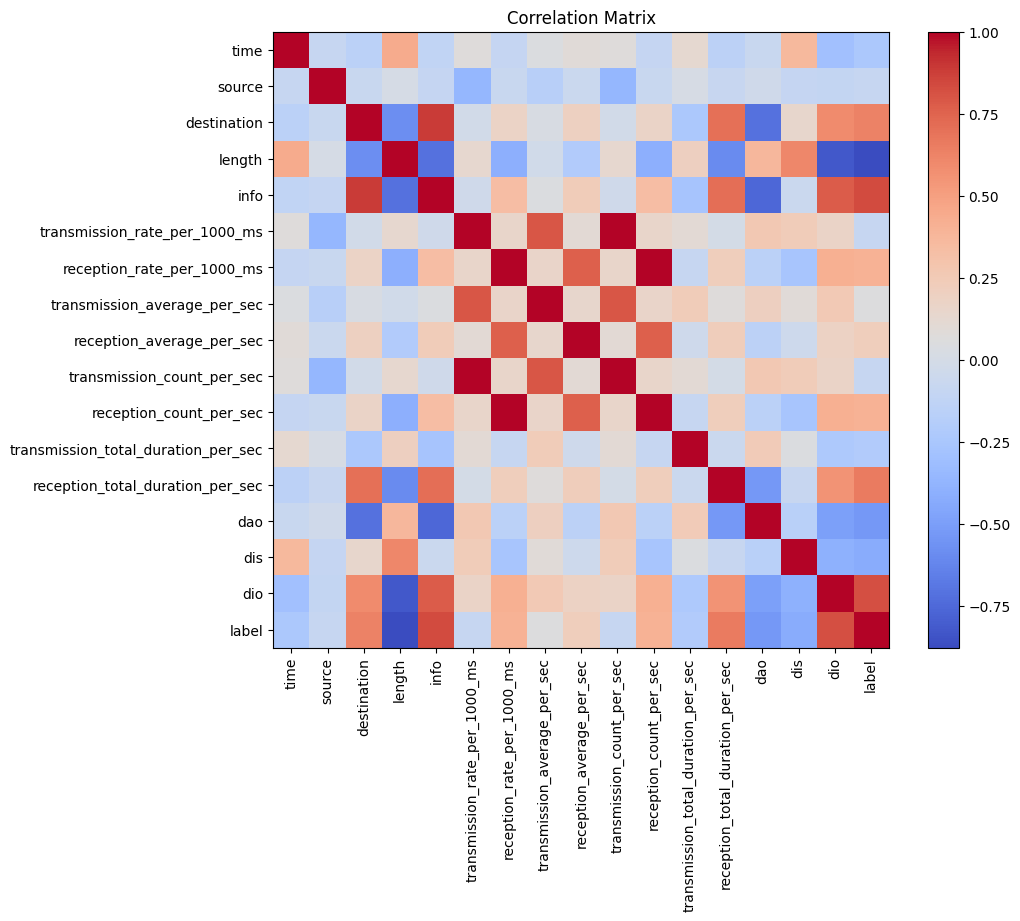

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns
numeric_df = df.select_dtypes(include='number')

# Compute the correlation matrix
correlation_matrix = numeric_df.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
plt.title('Correlation Matrix')
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.show()
